In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os


In [23]:
!pip install gdown
import gdown
url = "https://drive.google.com/uc?id=16hOWSbMpqJfpObMTs1rzCyWYabRw6Vd8"
output = "Teeth_Dataset.zip"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=16hOWSbMpqJfpObMTs1rzCyWYabRw6Vd8
From (redirected): https://drive.google.com/uc?id=16hOWSbMpqJfpObMTs1rzCyWYabRw6Vd8&confirm=t&uuid=45da298f-3c82-411c-8d5e-fabf593e300c
To: /content/Teeth_Dataset.zip
100%|██████████| 49.1M/49.1M [00:00<00:00, 107MB/s]


'Teeth_Dataset.zip'

In [24]:
import zipfile
with zipfile.ZipFile("Teeth_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Teeth_Dataset")
import os
print("Teeth_Dataset:")
print(os.listdir("Teeth_Dataset"))



Teeth_Dataset:
['Teeth_Dataset']


In [25]:
import os
inner_path = "Teeth_Dataset/Teeth_Dataset"
print("Teeth_Dataset/Teeth_Dataset:")
print(os.listdir(inner_path))

Teeth_Dataset/Teeth_Dataset:
['Testing', 'Training', 'Validation']


In [26]:
train_dir = "/content/Teeth_Dataset/Teeth_Dataset/Training"
val_dir = "/content/Teeth_Dataset/Teeth_Dataset/Validation"
test_dir = "/content/Teeth_Dataset/Teeth_Dataset/Testing"


In [27]:
!rm -rf /content/Teeth_Dataset/Teeth_Dataset/Testing/out \
         /content/Teeth_Dataset/Teeth_Dataset/Testing/outputs \
         /content/Teeth_Dataset/Teeth_Dataset/Testing/output \
         /content/Teeth_Dataset/Teeth_Dataset/Testing/output_image.jpg

In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
num_classes = train_generator.num_classes


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

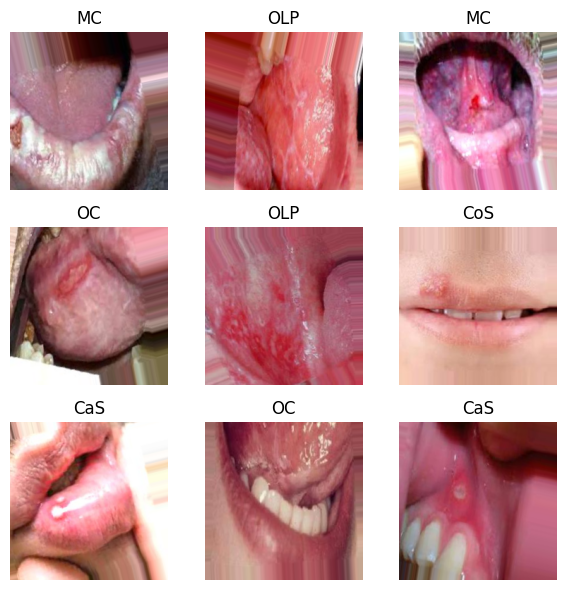

In [30]:
images,labels=next(train_generator)
plt.figure(figsize=(6,6))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  class_index=np.argmax(labels[i])
  class_name=list(train_generator.class_indices.keys())[class_index]
  plt.title(class_name)
  plt.axis("off")
plt.tight_layout()
plt.show()

In [31]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 21,125,167 (80.59 MB)

 Trainable params: 9,203,783 (35.11 MB)

 Non-trainable params: 11,921,384 (45.48 MB)

In [32]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)
call_backs=[early_stop,reduce_lr]

In [34]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=call_backs
)


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 557ms/step - accuracy: 0.5591 - loss: 1.2528 - val_accuracy: 0.7549 - val_loss: 1.1310 - learning_rate: 1.0000e-04
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 493ms/step - accuracy: 0.7381 - loss: 0.7589 - val_accuracy: 0.8804 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - accuracy: 0.8317 - loss: 0.4902 - val_accuracy: 0.9465 - val_loss: 0.3514 - learning_rate: 1.0000e-04
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 508ms/step - accuracy: 0.8901 - loss: 0.3344 - val_accuracy: 0.9698 - val_loss: 0.1413 - learning_rate: 1.0000e-04
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 503ms/step - accuracy: 0.9189 - loss: 0.2518 - val_accuracy: 0.9796 - val_loss: 0.0869 - learning_rate: 1.0000e-04
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 517ms/step - accuracy: 0.9410 - loss: 0.1825 - val_accuracy: 0.9864 - val_loss: 0.0562 - learning_rate: 1.0000e-04
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 567ms/step - acc

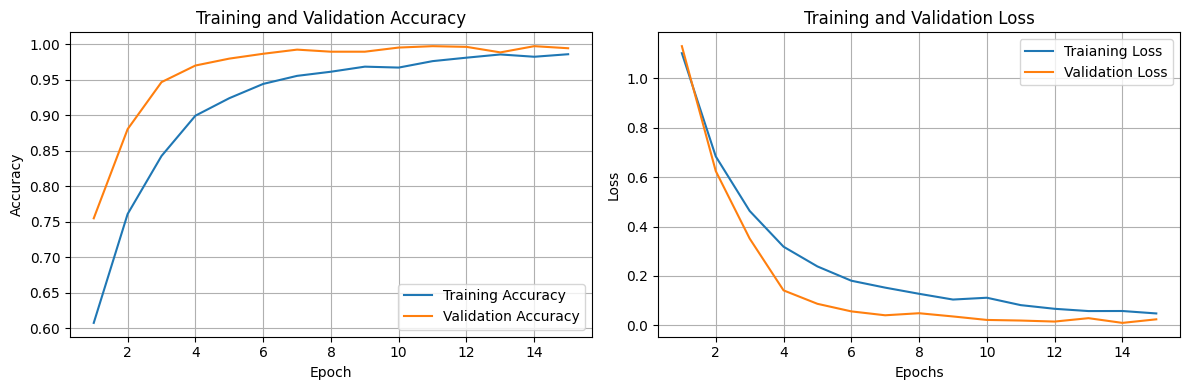

In [35]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(1,len(acc)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Traianing Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
test_loss,test_acc=model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc: .4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9964 - loss: 0.0110
Test Accuracy:  0.9951


In [39]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred=model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=test_generator.classes
print(classification_report(y_true,y_pred_classes,target_names=list(test_generator.class_indices.keys())))

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step
              precision    recall  f1-score   support

         CaS       1.00      0.99      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       0.98      1.00      0.99       120
          MC       0.99      1.00      0.99       180
          OC       0.99      0.98      0.99       108
         OLP       1.00      0.99      1.00       180
          OT       1.00      0.99      1.00       131

    accuracy                           1.00      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       1.00      1.00      1.00      1028



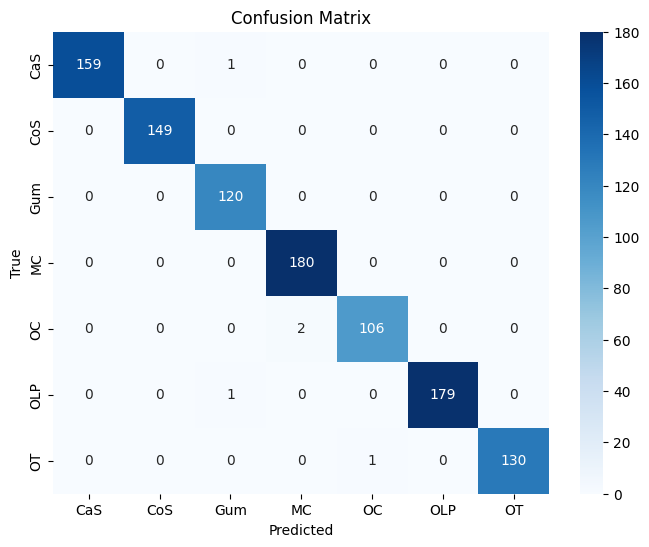

In [41]:
cm=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [43]:
labels = list(test_generator.class_indices.keys())
print(labels)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [48]:
from tensorflow import keras
model.save("Xception_finetuned.keras", save_format="keras")


In [49]:
from google.colab import files
files.download('Xception_finetuned.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>